In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('logs/bo_runs_data_tempswing_Vext_100b.csv')
doto = pd.read_csv('logs/gp_summary_data_tempswing_Vext_100b.csv', on_bad_lines='skip')


In [2]:
counts = data['found_global_best'].value_counts()
print(counts)

found_global_best
False    347
True     193
Name: count, dtype: int64


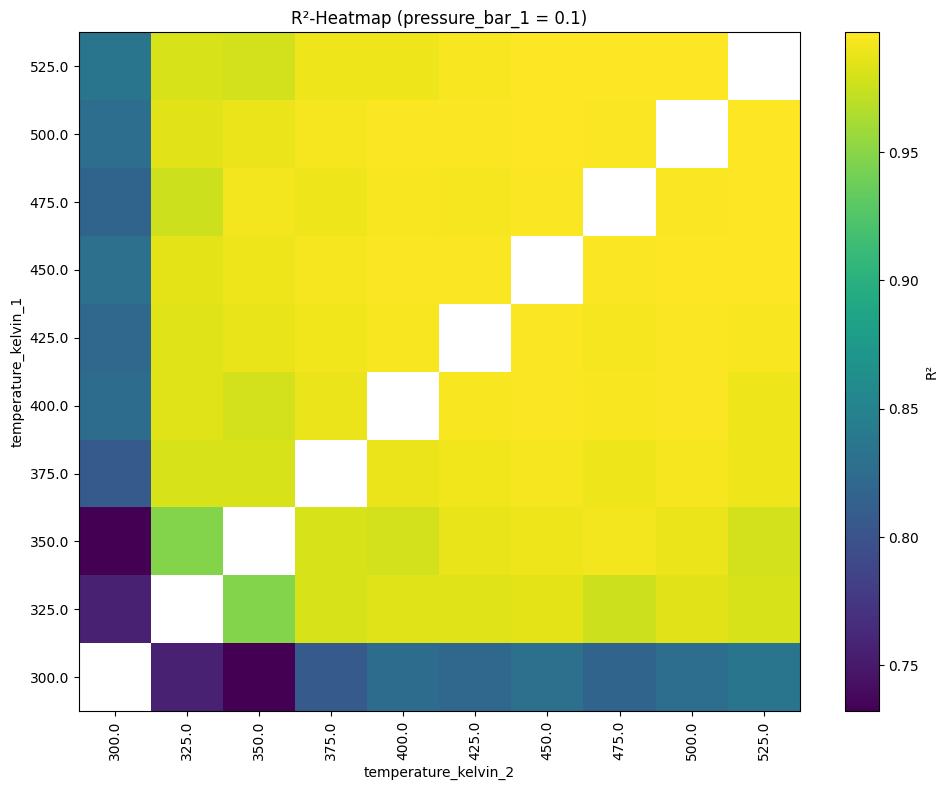

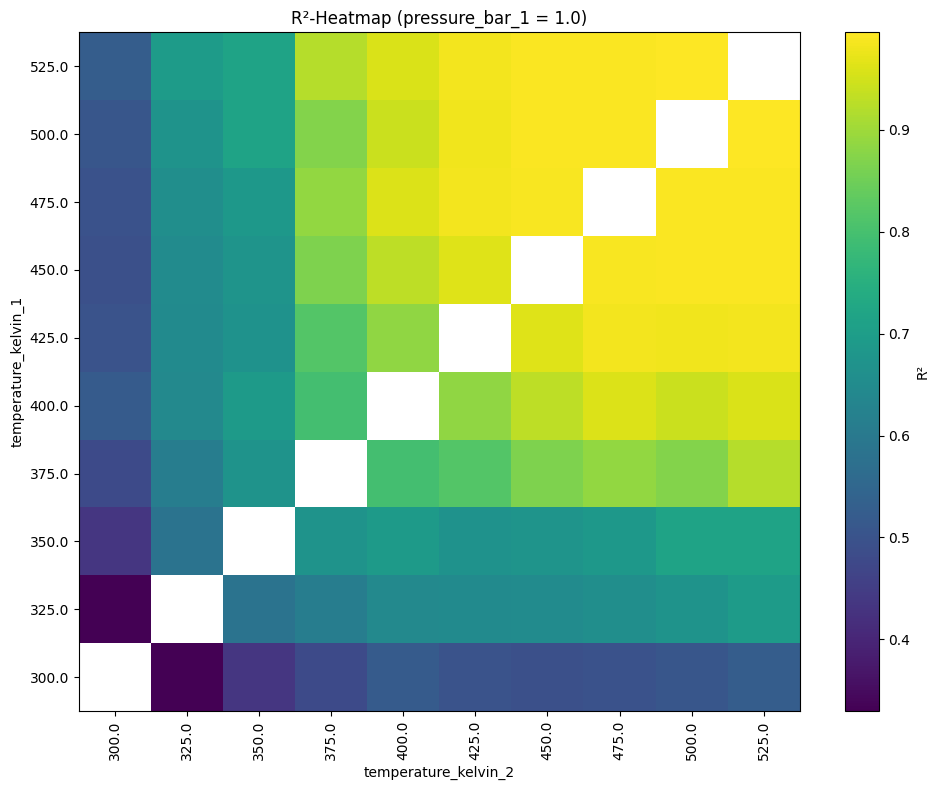

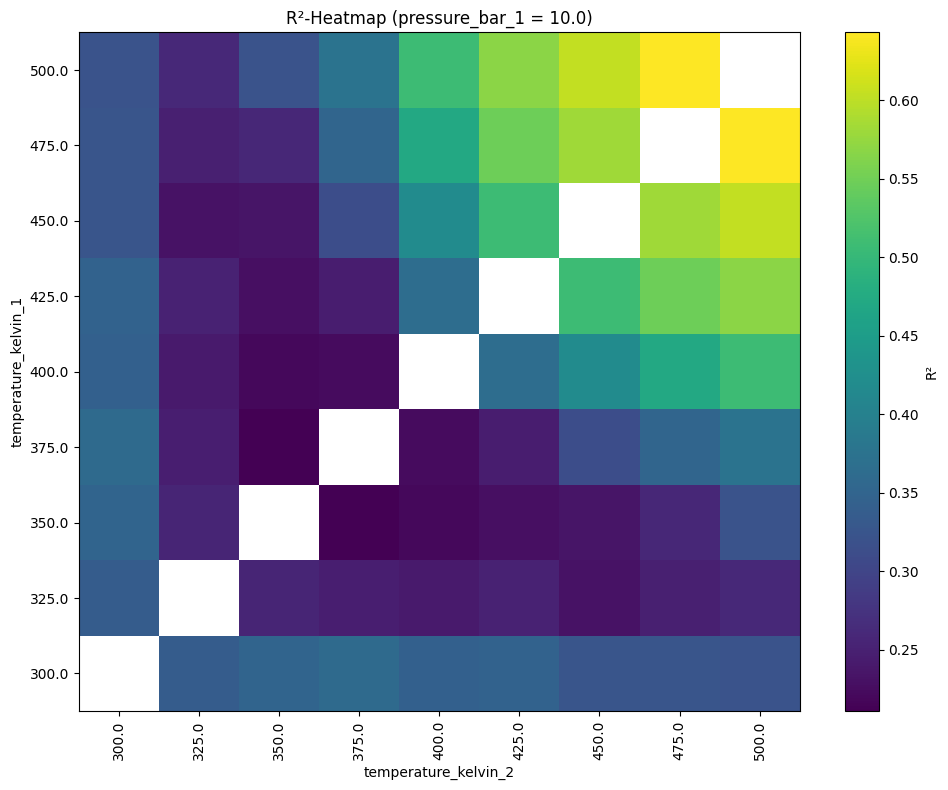

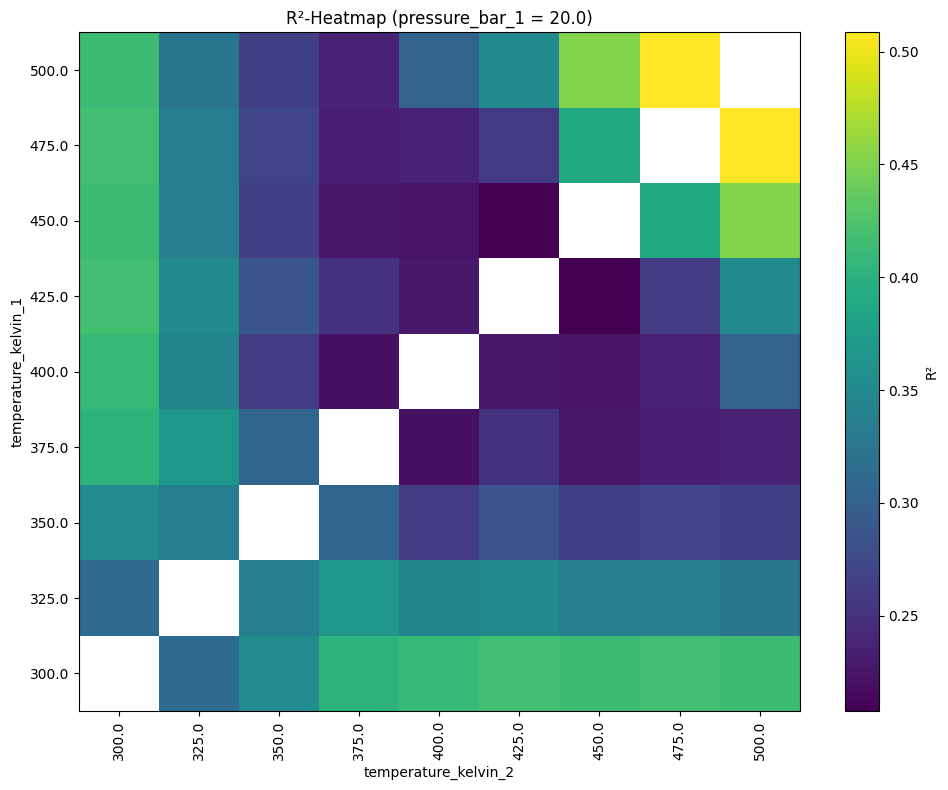

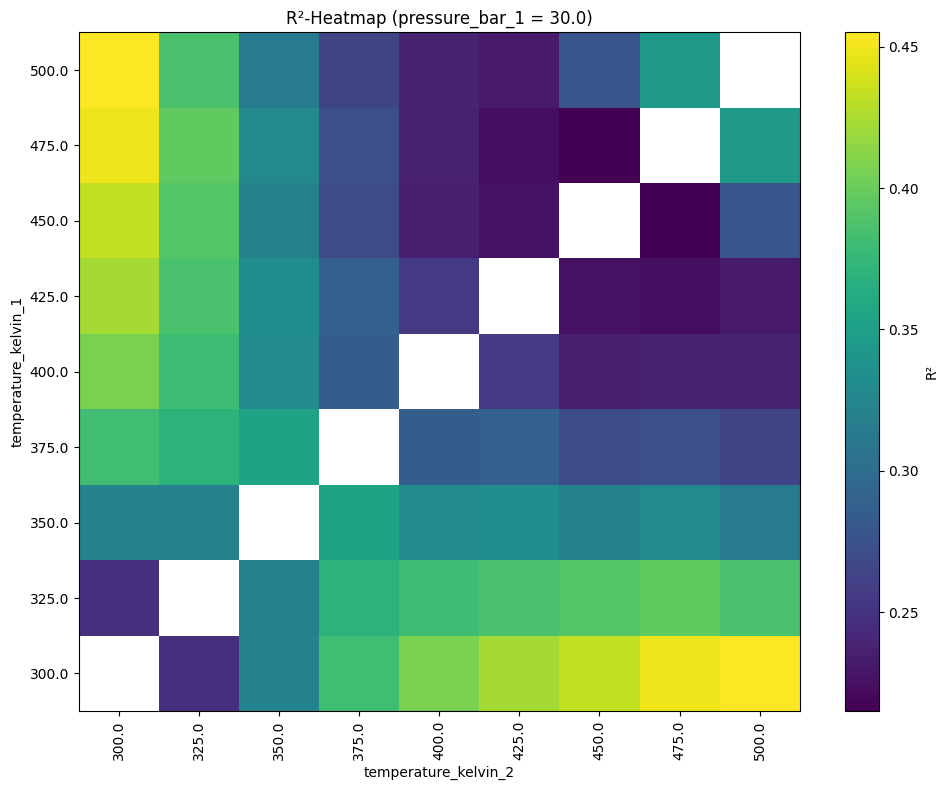

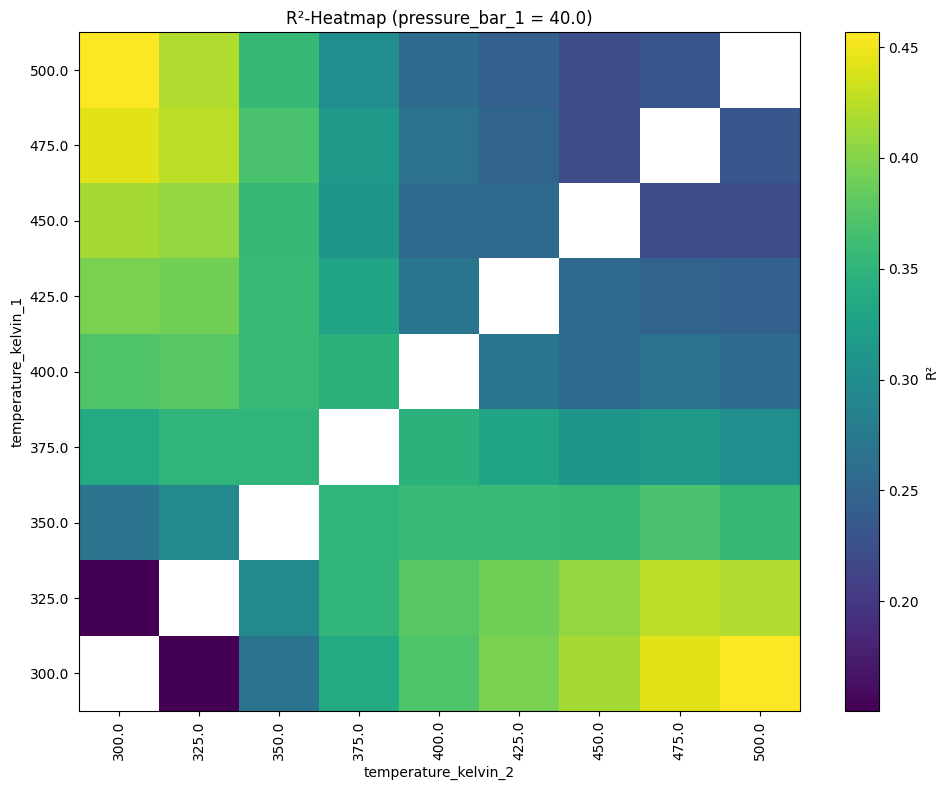

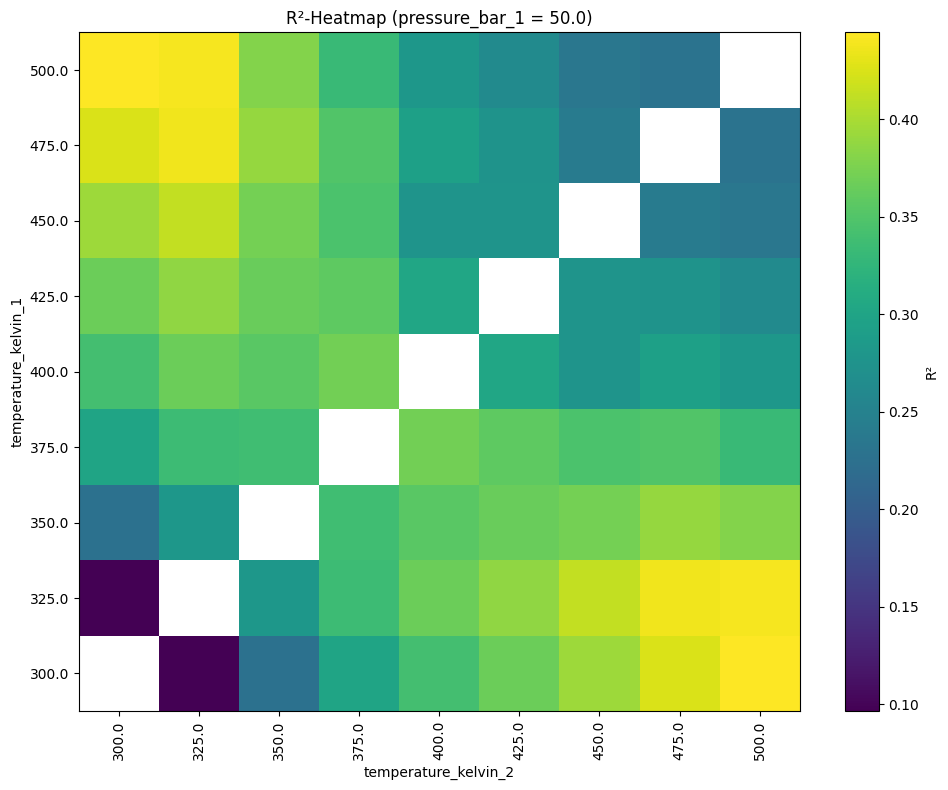

In [3]:
pressures = np.sort(doto["pressure_bar_1"].unique())

for p in pressures:
    # 2) Nicht das Original-DF überschreiben; Subset je Druck bauen
    sub = doto[doto["pressure_bar_1"].eq(p)]

    if sub.empty:
        continue  # falls numerische Toleranzen o.ä.

    # 3) Pivot-Table (optional: Mittelwert bei Duplikaten)
    heatmap_data = sub.pivot_table(
        index="temperature_kelvin_1",
        columns="temperature_kelvin_2",
        values="r2",
        aggfunc="mean"
    )

    # Optional: sortierte Achsen (macht die Heatmap „ordentlicher“)
    heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

    # 4) Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_data.values, aspect='auto', origin='lower')
    plt.colorbar(label='R²')

    plt.title(f"R²-Heatmap (pressure_bar_1 = {p})")
    plt.xlabel("temperature_kelvin_2")
    plt.ylabel("temperature_kelvin_1")

    # Achsen-Ticks passend zu den DataFrame-Achsen setzen
    plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
    plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

    plt.tight_layout()
    plt.show()

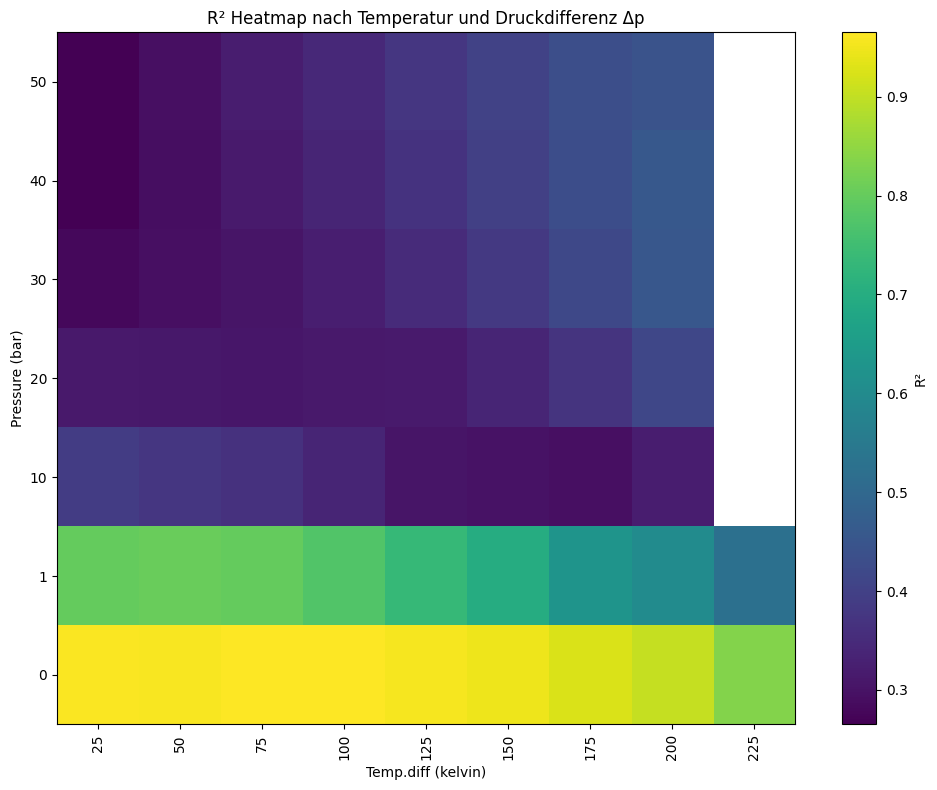

In [4]:
doto["delta_t"] = (doto["temperature_kelvin_2"] - doto["temperature_kelvin_1"]).abs()

# --- Pivot-Tabelle: Temperatur vs Δp ---
heatmap_data = doto.pivot_table(
    index="pressure_bar_1",   # Y-Achse
    columns="delta_t",            # X-Achse
    values="r2",                  # Farbe repräsentiert R²
    aggfunc="mean"                # Mittelwert, falls mehrere Kombinationen
)

# --- Sortierung (optional, für saubere Achsen) ---
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# --- Plot ---
plt.figure(figsize=(10, 8))
im = plt.imshow(heatmap_data, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(im, label="R²")

plt.title("R² Heatmap nach Temperatur und Druckdifferenz Δp")
plt.xlabel("Temp.diff (kelvin)")
plt.ylabel("Pressure (bar)")

# Achsenbeschriftungen mit tatsächlichen Werten
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns.astype(int), rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index.astype(int))

plt.tight_layout()
plt.show()

In [5]:
data=data[data["found_global_best"]==True]

In [6]:
data

,timestamp,temperature_kelvin_T1,temperature_kelvin_T2,pressure_bar_1,pressure_bar_2,n_candidates,n_iterations,best_value,global_best_value,found_global_best
0,2025-11-11T15:59:44,300.0,325.0,0.1,0.1,245,30,0.000998,0.000998,True
1,2025-11-11T15:59:51,300.0,350.0,0.1,0.1,245,19,0.001635,0.001635,True
2,2025-11-11T16:00:01,300.0,375.0,0.1,0.1,245,37,0.002033,0.002033,True
3,2025-11-11T16:00:09,300.0,400.0,0.1,0.1,245,29,0.002214,0.002214,True
4,2025-11-11T16:00:17,300.0,425.0,0.1,0.1,245,26,0.002301,0.002301,True
...,...,...,...,...,...,...,...,...,...,...
524,2025-11-11T18:04:07,475.0,300.0,50.0,50.0,245,14,0.004965,0.004965,True
525,2025-11-11T18:04:20,475.0,325.0,50.0,50.0,245,28,0.004403,0.004403,True
526,2025-11-11T18:04:33,475.0,350.0,50.0,50.0,245,35,0.004133,0.004133,True
531,2025-11-11T18:05:18,475.0,500.0,50.0,50.0,245,14,0.000818,0.000818,True


In [7]:
doto

,run_started_at,timestamp,temperature_kelvin_1,temperature_kelvin_2,pressure_bar_1,pressure_bar_2,n_rows,r2,median_APE_pct,mean_APE_pct,count_APE_gt_20pct,max_APE_pct,folds,delta_t
0,2025-11-11T15:59:35,2025-11-11T15:59:39,300.0,325.0,0.1,0.1,245,0.756398,12.745842,126188.788988,96,2.406318e+07,"1,2,3,4,5,6,7,8,9,10",25.0
1,2025-11-11T15:59:35,2025-11-11T15:59:48,300.0,350.0,0.1,0.1,245,0.732130,11.948277,34809.704619,79,8.511945e+06,"1,2,3,4,5,6,7,8,9,10",50.0
2,2025-11-11T15:59:35,2025-11-11T15:59:55,300.0,375.0,0.1,0.1,245,0.806767,11.342731,74510.242427,62,1.824373e+07,"1,2,3,4,5,6,7,8,9,10",75.0
3,2025-11-11T15:59:35,2025-11-11T16:00:05,300.0,400.0,0.1,0.1,245,0.825819,11.660156,10446.133220,71,2.549406e+06,"1,2,3,4,5,6,7,8,9,10",100.0
4,2025-11-11T15:59:35,2025-11-11T16:00:13,300.0,425.0,0.1,0.1,245,0.820479,9.941470,46.787418,62,2.122464e+03,"1,2,3,4,5,6,7,8,9,10",125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,2025-11-11T15:59:35,2025-11-11T18:05:53,500.0,375.0,50.0,50.0,245,0.331852,18.661282,49172.589288,115,4.720365e+06,"1,2,3,4,5,6,7,8,9,10",125.0
536,2025-11-11T15:59:35,2025-11-11T18:06:01,500.0,400.0,50.0,50.0,245,0.280433,17.765276,48232.119589,119,4.489636e+06,"1,2,3,4,5,6,7,8,9,10",100.0
537,2025-11-11T15:59:35,2025-11-11T18:06:10,500.0,425.0,50.0,50.0,245,0.263337,18.102955,49322.961610,113,4.339765e+06,"1,2,3,4,5,6,7,8,9,10",75.0
538,2025-11-11T15:59:35,2025-11-11T18:06:19,500.0,450.0,50.0,50.0,245,0.234771,18.723074,49036.255272,111,4.140348e+06,"1,2,3,4,5,6,7,8,9,10",50.0
